In [2]:
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from scipy.io import loadmat
import loaders
from preprocessing.vsdi_preprocessing import clean_outliers,pca_ica,glm
from pathlib import Path

# Match masks

In [33]:
from itertools import product

animals = ['A04','A06','A07','A08']
days = ['Day1','Day3','Day5','Day7']

masks = []
for animal,day in product(animals,days):
    try:
        mask = loadmat(datapath.joinpath(f'{animal}/{day}/vsdi_mask.mat'))['mask']
        masks.append(mask)

    except FileNotFoundError:
        print(f"Not found mask for {animal},{day}")
        masks.append(np.nan)
        continue
    except OSError:
        print(f"OS error for {animal},{day}")
        masks.append(np.nan)
        continue
    


In [38]:
len(masks)

16

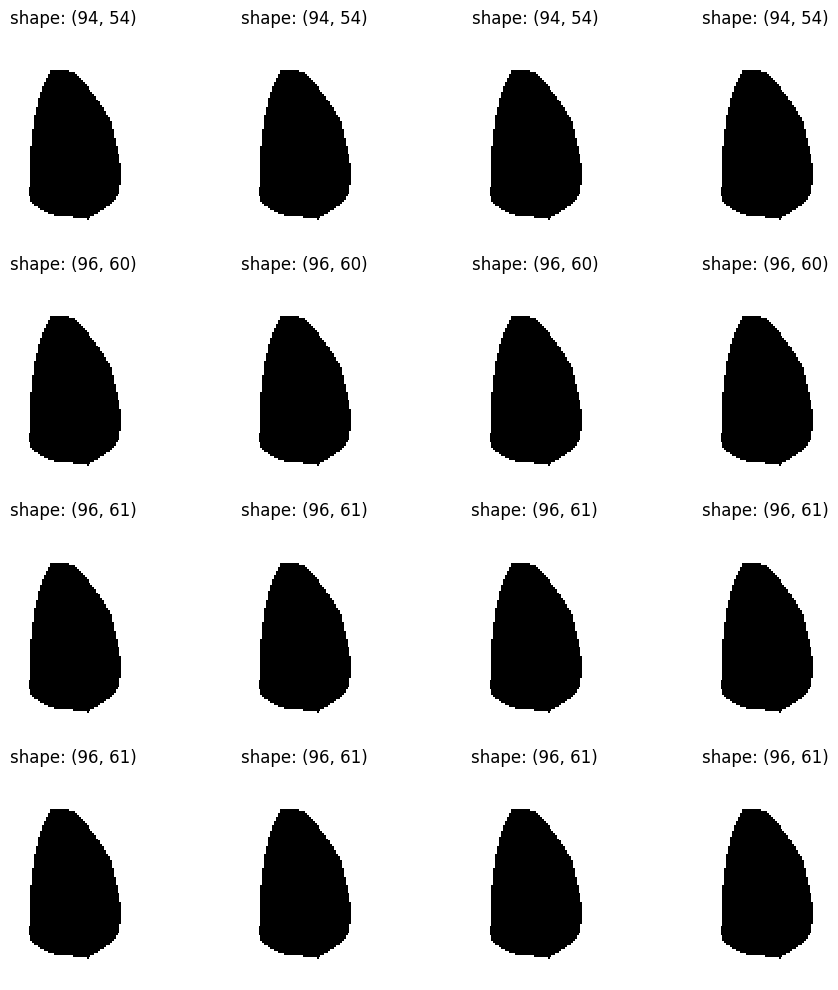

In [42]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i,m in enumerate(masks):
    ax = plt.subplot(4,4,i+1)
    ax.matshow(mask,cmap=plt.cm.Greys)
    plt.axis('off')
    plt.title(f'shape: {m.shape}')

plt.tight_layout()


In [89]:
from functools import reduce
def max_common_intersection(mask_list):
    min_x = np.min([m.shape[0] for m in mask_list])
    min_y = np.min([m.shape[1] for m in mask_list])

    cropped_masks = []
    for m in masks:
        if m.shape[0]> min_x and m.shape[1]>min_y:
            cropped_masks.append(m[(m.shape[0]-min_x)//2:-(m.shape[0]-min_x)//2,
                       (m.shape[1]-min_y)//2:-(m.shape[1]-min_y)//2])

        elif m.shape[0] == min_x and m.shape[1]>min_y:
            cropped_masks.append(m[:,(m.shape[1]-min_y)//2:-(m.shape[1]-min_y)//2])

        elif m.shape[0]> min_x and m.shape[1]== min_y:
            cropped_masks.append(m[(m.shape[0]-min_x)//2:-(m.shape[0]-min_x)//2,:])

        else:
            cropped_masks.append(m)
            
    # performs elementwise logical and
    intersection = reduce(lambda x, y: np.logical_and(x, y), cropped_masks)


    return intersection

In [90]:
cm = max_common_intersection(masks)

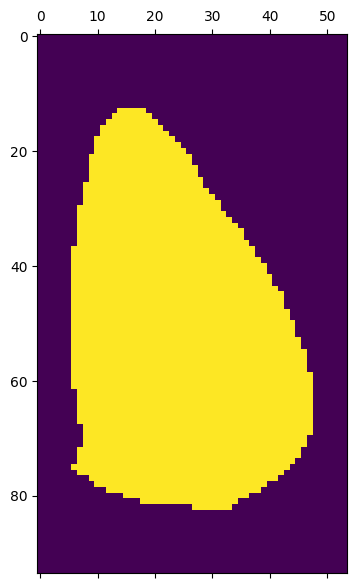

In [91]:
plt.matshow(cm)